In [1]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt 
import module.content as content
import module.features as features
from joblib import load
import argparse
import time

In [2]:
# this block assign the parameter: (like args_extractor)
model_4D = 'mini_kmeans_4D_3_3x3'
model_3D = 'mini_kmeans_3D_3_3x3'
size = 3
timestamp = 5
index_slice = 600

In [3]:
# this block don't need to be changed
# Here we set the paramater
mask_centre = (700, 810)
radius = 550

# get the path for target slice
current_path = os.getcwd()
print(current_path)
all_timestamp = content.get_folder(current_path)
sub_path = os.path.join(current_path, all_timestamp[timestamp])
sub_all_tif = content.get_allslice(sub_path)
target_slice = sub_all_tif[index_slice]

# load the model from 'model' folder
model_4D_path = os.path.join(current_path, 'model', model_4D+'.model')
model_3D_path = os.path.join(current_path, 'model', model_3D+'.model')
model_4D_type = load(model_4D_path)
model_3D_type = load(model_3D_path)

# get features
mask, feature_index = features.get_mask(sub_all_tif[0], mask_centre, radius, size)
if size == 1:
    feature_4D, feature_3D = features.get_all_features_1(target_slice, feature_index)
elif size == 3:
    feature_4D, feature_3D = features.get_all_features_3(target_slice, feature_index)
elif size == 5:
    feature_4D, feature_3D = features.get_all_features_5(target_slice, feature_index)
else:
    raise ValueError('Please input the right size, should be 1, 3 or 5.')
    
# segment
prediction_4D = model_4D_type.predict(feature_4D)
prediction_3D = model_3D_type.predict(feature_3D)

/Users/gavin/MSc-Project
Pick one slice to get mask and features index
Current slice: /Users/gavin/MSc-Project/SHP15_T113_0025/SHP15_T113__0025_0601.rec.16bit.tif
Loading 9 images...
Finished!
Getting features...
Finished!
Concatenating features...
Finished!


In [4]:
# this block to write the whole picture
# we need to find which label represents pore
coordinate = mask.nonzero()
height, width = mask.shape
final_img_4D = np.ones((height,width), np.uint8)
final_img_3D = np.ones((height,width), np.uint8)
for i in range(coordinate[0].shape[0]):
    final_img_4D[coordinate[0][i], coordinate[1][i]] = prediction_4D[i]
    final_img_3D[coordinate[0][i], coordinate[1][i]] = prediction_3D[i]

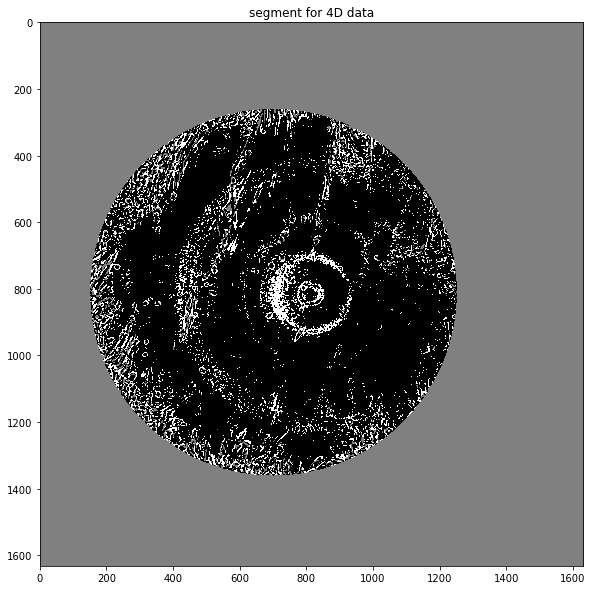

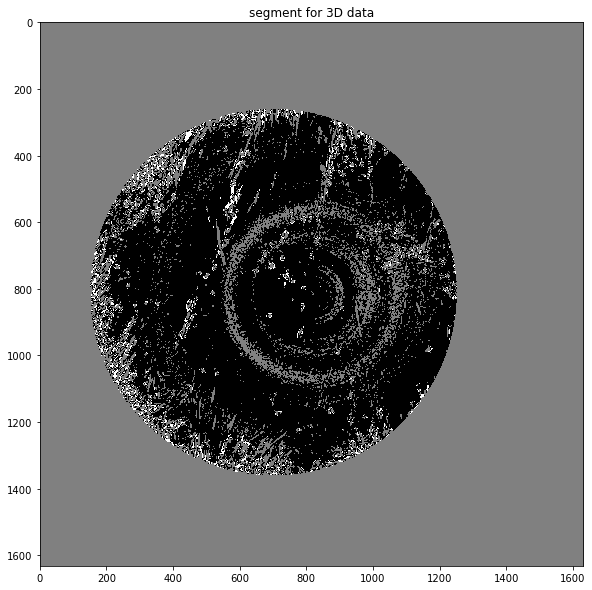

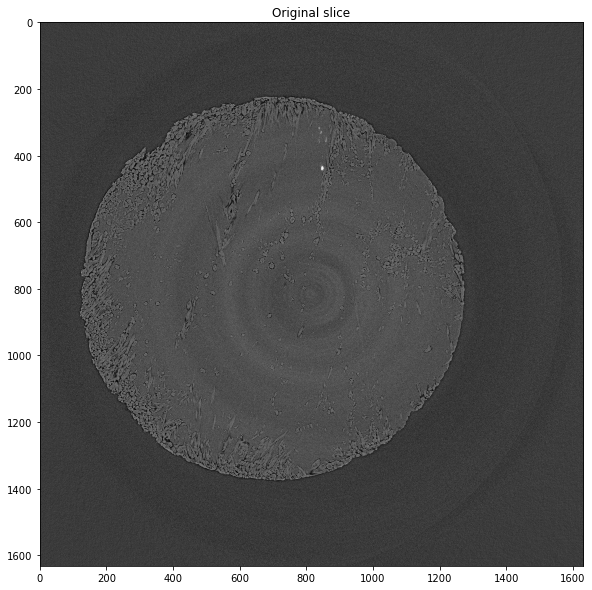

In [5]:
# this block plot the image: 4D seg, 3D seg, original img
plt.figure(figsize=(10,10))
plt.imshow(final_img_4D,'gray')
plt.title('segment for 4D data')

plt.figure(figsize=(10,10))
plt.imshow(final_img_3D,'gray')
plt.title('segment for 3D data')

plt.figure(figsize=(10,10))
img = cv2.imread(target_slice, -1)
plt.imshow(img, 'gray')
plt.title('Original slice')
plt.show()

In [11]:
# set the pore label for 4D, and write the new image
pore_4D = 1
# here need to assign the pore label manually. 
# Since the classfier will return the label randomly
zero_point_4D_co = np.argwhere(prediction_4D==pore_4D)
# class "1" in 4D model means pore

height, width = mask.shape
final_img_4D_po = np.ones((height,width), np.uint8)

for i in zero_point_4D_co:
    final_img_4D_po[coordinate[0][i], coordinate[1][i]] = 0

In [7]:
# set the pore label for 3D, and write the new image
pore_3D = 2
# here need to assign the pore label manually. 
# Since the classfier will return the label randomly
zero_point_3D_co = np.argwhere(prediction_3D==pore_3D)

height, width = mask.shape
final_img_3D_po = np.ones((height,width), np.uint8)

for j in zero_point_3D_co:
    final_img_3D_po[coordinate[0][j], coordinate[1][j]] = 0

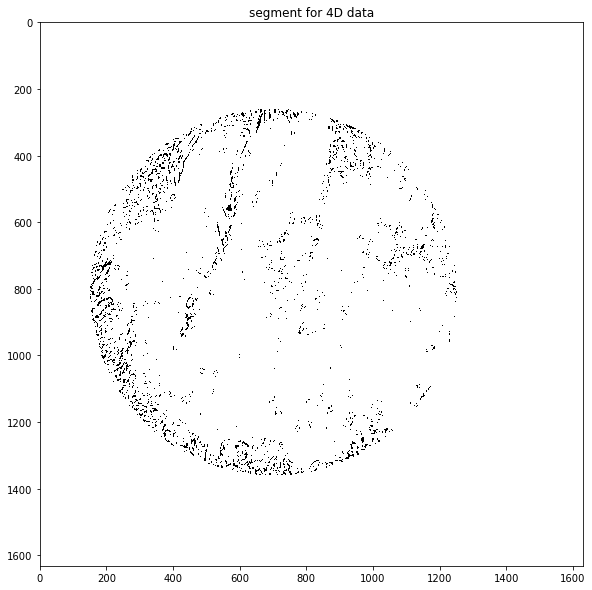

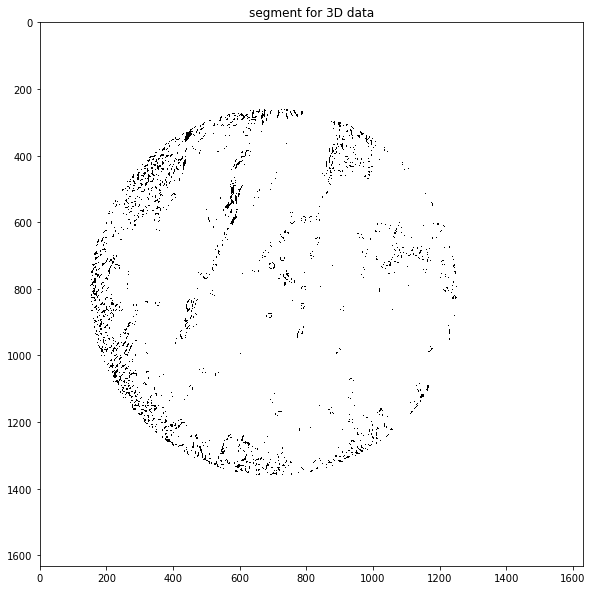

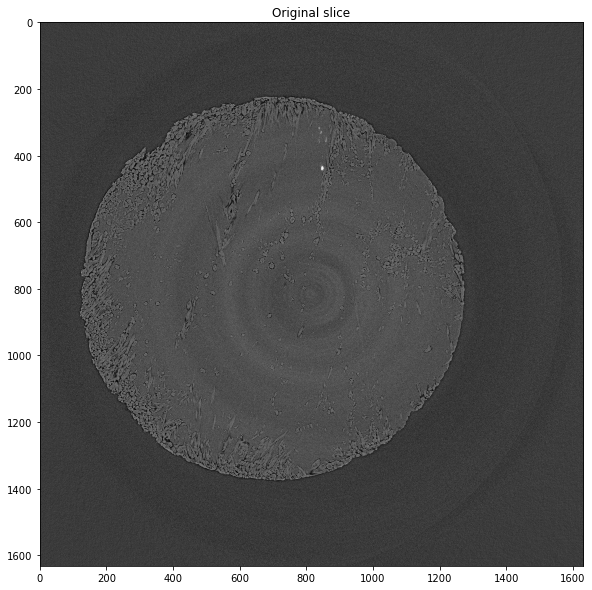

In [12]:
# this block plot the final image: 4D seg, 3D seg, original img
plt.figure(figsize=(10,10))
plt.imshow(final_img_4D_po,'gray')
plt.title('segment for 4D data')

plt.figure(figsize=(10,10))
plt.imshow(final_img_3D_po,'gray')
plt.title('segment for 3D data')

plt.figure(figsize=(10,10))
img = cv2.imread(target_slice, -1)
plt.imshow(img, 'gray')
plt.title('Original slice')
plt.show()